## Библиотеки, параметры, константы задачи

In [1]:
from applications.poly_features_environment import PolyFeaturesEnv
import torch
import models
import numpy as np
from common.fstream import read_tensor, read_matrix, rescale_array, read_mc_tensor

PATH_BASE = "/home/amedvedev/projects/python/DenoisingCNN"
NAME_DATASET = "gcg19"
env = PolyFeaturesEnv(name_model="uvych_matrix_embedding", name_dataset=NAME_DATASET, path_base=PATH_BASE,
                      device_name="cpu")


## Загрузка данных

In [2]:
import torchvision



env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=32, val_batch_size=4
    ) \
    .load_feature(
        shape=(1, 80, 80), feature_name="Uvych2_noised_abs_rotated.xls", mapper=read_tensor, transform=None
    ) \
    .set_target(
        shape=(1, 80, 80), target_name="Uvych2_abs_rotated.xls", mapper=read_tensor, transform=None
    ) \

print(env.train_count, env.val_count)

27 16loading progress: |██████████████████████████████████████████████----| 93.8% Complete | 


## Модели

### Новая локальная модель

In [5]:
env.set_name_model("uvych_tensor_denoiser_3_(re)")

In [ ]:
from torch import nn
class UvychDimExpand(nn.Module):
    def __init__(self, width, height, hidden_size):
        super(UvychDimExpand, self).__init__()

        self.width = width
        self.height = height
        self.orig_size = width * height
        self.hidden_size = hidden_size

        self.ft = nn.Sequential(
            nn.Linear(self.orig_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.Sigmoid(),
        )

        self.inv = nn.Linear(hidden_size, self.orig_size)

    def forward(self, x):
        bs = x.size()[0]
        orig_shape = tuple(x.shape)
        x = x.view(bs, self.height * self.width)
        h = self.ft(x)
        x = self.inv(h)
        x = x.view(orig_shape)

        return x

    def embedding(self, x):
        h = self.ft(x)
        return h



In [3]:
env.model = models.autoencoders.ConvAutoencoderLumaRelu10(in_channels=1, out_channels=1).to(env.device)


In [3]:
env.model = models.autoencoders.unet.UNet(in_channels=1, out_channels=1, init_features=64).to(env.device)


In [18]:
env.model = models.embeddings.uvych_dim_expand.UvychDimExpand(width=80, height=80, hidden_size=80*30).to(env.device)

In [3]:
env.model = models.gans.vqgan.VQGAN_mod(type('', (object, ), 
    {'image_channels': 1, 'latent_dim': 256, 'device': env.device_name, 
     'num_codebook_vectors': 1024, 'beta': 0.25})()).to(env.device)

In [13]:
env.model

VQGAN_mod(
  (encoder): Encoder(
    (model): Sequential(
      (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ResidualBlock(
        (block): Sequential(
          (0): GroupNorm(
            (gn): GroupNorm(32, 128, eps=1e-06, affine=True)
          )
          (1): Swish()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): GroupNorm(
            (gn): GroupNorm(32, 128, eps=1e-06, affine=True)
          )
          (4): Swish()
          (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (channel_up): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      )
      (2): ResidualBlock(
        (block): Sequential(
          (0): GroupNorm(
            (gn): GroupNorm(32, 128, eps=1e-06, affine=True)
          )
          (1): Swish()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): GroupNorm(
            (gn): Grou

### Импорт претренерованной модели

In [4]:
env.load_model(model_type="pt")

## Визуализация батча валидационного датасета

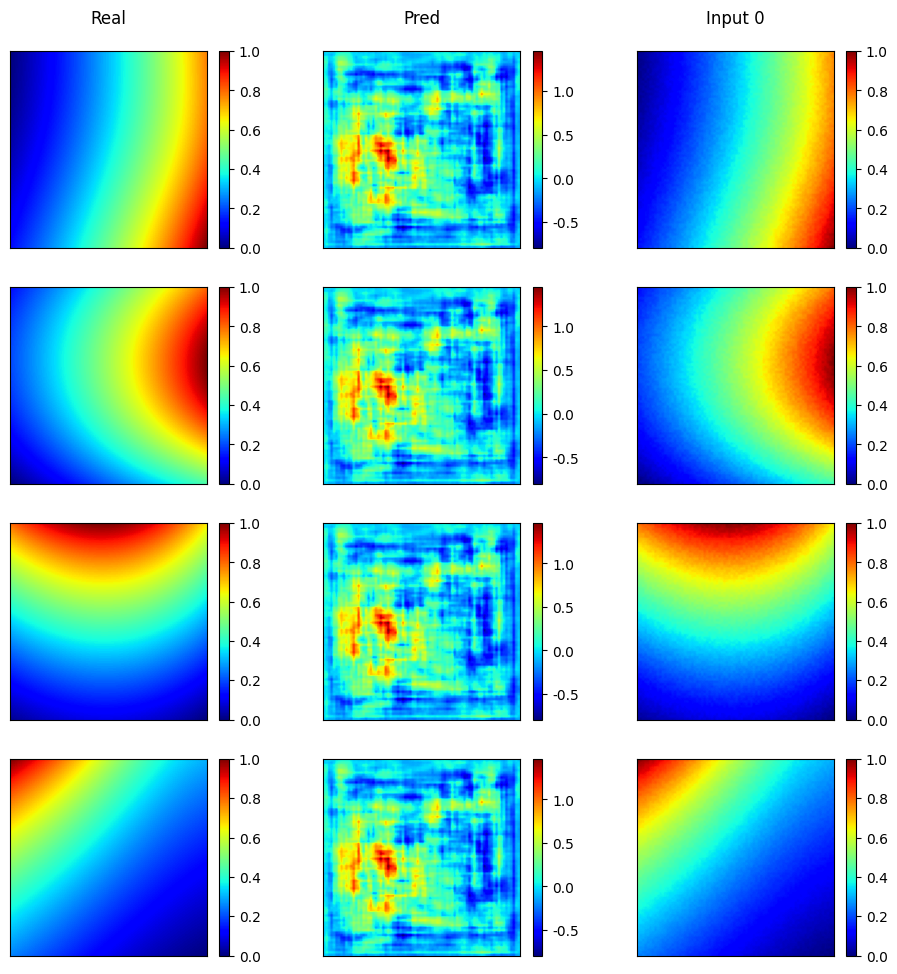

In [14]:
env.plot_batch_with_inputs(concrete=0, figsize=(10, 10), format="%.1f", wspace=0.0, hspace=0.2)


/home/amedvedev/projects/python/DenoisingCNN/venv/lib/python3.10/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


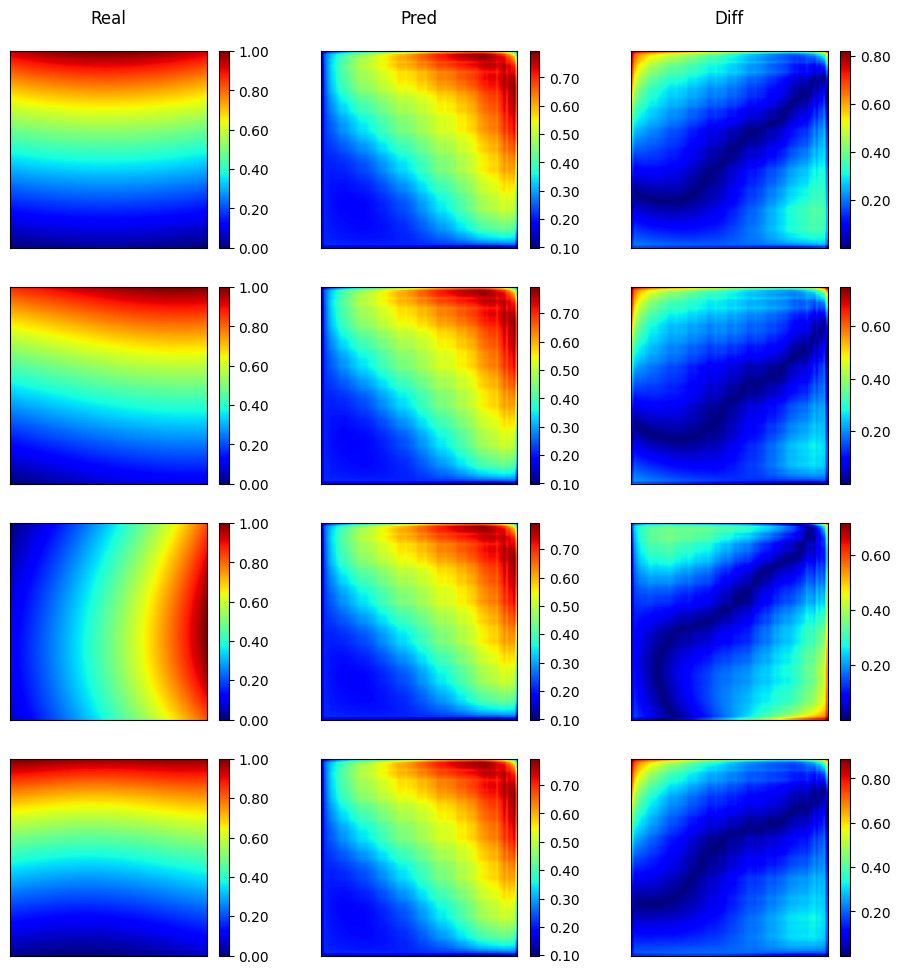

In [7]:
env.plot_batch(concrete=7, figsize=(10, 10), format="%.2f", wspace=0.0, hspace=0.2)


## Численные значения отклонений

In [6]:
def test():
    losses = []
    errors = []
    init_errors = []
    losses_dataset = []
    with torch.no_grad():
    
        for row in zip(*env.val_features_loaders + [env.val_target_loader]):
            data_features = list(row)
            data_target = data_features.pop()
            outputs = env.model(*data_features) #* 65.
            
            for ex_id in range(env.val_batch_size):

                losses_dataset_step = torch.mean(torch.abs(data_features[0][ex_id][0] - data_target[ex_id])).detach().tolist()
                losses_dataset.append(losses_dataset_step)
                
                init_error = torch.mean(torch.abs(data_features[0][ex_id][0] - data_target[ex_id]) / data_target[ex_id])
                init_errors.append(init_error.detach().tolist())
                
                loss = torch.mean(torch.abs(outputs[ex_id] - data_target[ex_id]))
                losses.append(loss.detach().tolist())
                # print(data_target[ex_id].size())
                
                
                error = torch.mean(torch.abs(outputs[ex_id] - data_target[ex_id]) / data_target[ex_id])
                errors.append(error.detach().tolist())
                #print(outputs, data_target)
                
    print("Начальное среднее отклонение по значениям:", sum(losses_dataset) / len(losses_dataset))
    print("Текущее среднее отклонение по значениям:", sum(losses) / len(losses))
    
    print()
    print("Начальное максимальное отклонение по значениям:", max(losses_dataset))
    print("Текущее максимальное отклонение по значениям в векторе:", max(losses))
    
    print()
    print("Начальная средняя относительная ошибка:", sum(init_errors) / len(init_errors))
    print("Текущая средняя относительная ошибка:", sum(errors) / len(errors))
    print()
    print("Начальная максимальная относительная ошибка:", max(init_errors))
    print("Текущая максимальная относительная ошибка:", max(errors))
test()

Начальное среднее отклонение по значениям: 0.00657761879847385
Текущее среднее отклонение по значениям: 0.1491288963588886

Начальное максимальное отклонение по значениям: 0.012936357408761978
Текущее максимальное отклонение по значениям в векторе: 0.2457265704870224

Начальная средняя относительная ошибка: nan
Текущая средняя относительная ошибка: inf

Начальная максимальная относительная ошибка: inf
Текущая максимальная относительная ошибка: inf


## Training

In [9]:
from common.losses import MseCoeffLoss, L1CoeffLoss

In [24]:
env.set_name_model("uvych_tensor_denoiser_2")

In [4]:
opt = torch.optim.Adam(env.model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=4)


In [5]:
env.train(5, step_saving=False, step_plotting=False,
          optimizer=opt, scheduler=None, 
          criterion=torch.nn.SmoothL1Loss(reduction="none", reduce="none"), callbacks=[lambda: scheduler.step(env.test_losses[-1])])


/home/amedvedev/projects/python/DenoisingCNN/venv/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 
Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 1 	Training Loss: 0.117492 	Validating Loss: 0.024751 	Time: 5.71 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 
Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 2 	Training Loss: 0.021915 	Validating Loss: 0.019163 	Time: 5.49 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 
Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 3 	Training Loss: 0.019690 	Validating Loss: 0.018583 	Time: 5.22 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 
Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 4 	Training Loss: 0.01928

## Сохранение модели

In [9]:
env.save(onnx=False, pth=False)

## Loss visualisation

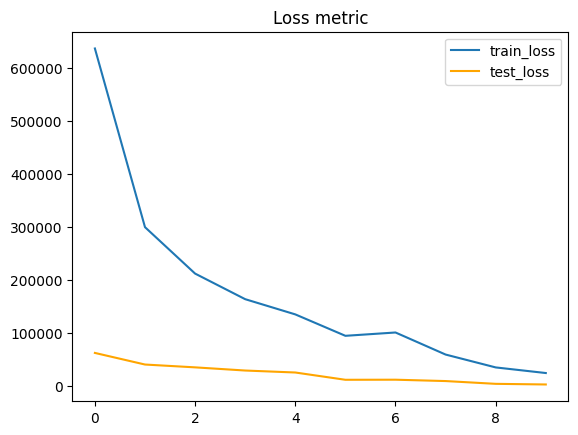

In [19]:
env.show_metrics(n_last=10, train=True, val=True)

## Clear memory

In [27]:
import gc
gc.collect()


42269

In [18]:
env.model.cpu()
del env.model
import torch
torch.cuda.empty_cache()